This notebook uses the images of the extracted faces from the real/fake videos in a folder layout:

Images/
    Train/
        Real/
        Fake/
    Val/
        Real/
        Fake/

I used EfficientNet (B3) [1] with pre-trained imagenet weights as the baseline model. EfficientNet can be installed via "pip install -U efficientnet". I chose this model for the baseline due to its efficiency in managing the size of the overall network and performance. The layers from the efficient net were frozen and new trainable layers were added for fine-tuning. There is scope for unfreezing some pre-trained layers for better performance. 

The data generators used a rescale function of 1./255 as a form of normalising the pixel values. Zoom, shear, and horizontal flips were added transforms as it is common for a wide range of videos to contain faces of varying distances / shear / and orientations from/to the camera. There is scope for these transforms to be fine-tuned for better performance. 

[1] Tan, Mingxing, and Quoc V. Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." arXiv preprint arXiv:1905.11946 (2019).

In [17]:
'''
#Jupyter notebooks create hidden checkpoint folders which may skew the number of classes 
#detected by the data generators. In this event, use the following code to delete the hidden folders.

import shutil
shutil.rmtree("Images/Train/.ipynb_checkpoints")
shutil.rmtree("Images/Val/.ipynb_checkpoints")
'''

In [60]:
from keras import applications
from efficientnet.keras import EfficientNetB3
from keras import callbacks
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from efficientnet.keras import EfficientNetB0 
from efficientnet.keras import center_crop_and_resize, preprocess_input
from keras import models, layers, optimizers

In [106]:
img_size = 224
batch_size = 16
num_train = 1714
num_val = 226
train_dir = 'Images/Train'
val_dir = 'Images/Val'

train_datagen = ImageDataGenerator( 
                rescale = 1. / 255, 
                 shear_range = 0.2, 
                  zoom_range = 0.2, 
            horizontal_flip = True,
                fill_mode='nearest') 
  
test_datagen = ImageDataGenerator(rescale = 1. / 255) 
  
train_generator = train_datagen.flow_from_directory(
                                            train_dir, 
                    target_size =(img_size, img_size), 
                                batch_size = batch_size, 
                                class_mode ='binary') 
  
validation_generator = test_datagen.flow_from_directory( 
                                                val_dir, 
                        target_size =(img_size, img_size), 
                                    batch_size = batch_size, 
                                    class_mode ='binary') 

Found 1714 images belonging to 2 classes.
Found 226 images belonging to 2 classes.


In [121]:
input_shape = (224, 224, 3)

#Use transfer learning for the first set of layers
#Include pre-trained imagenet weights
eff_net = EfficientNetB3(
        weights='imagenet',
    input_shape=input_shape,
            include_top=False
)

In [122]:
#Add fully connected final layers to fine-tune training to specific task
model = Sequential()
model.add(eff_net)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
flatten_13 (Flatten)         (None, 75264)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               19267840  
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)             

In [123]:
print('This is the number of trainable layers '
      'before freezing eff_net base:', len(model.trainable_weights))

#Freeze the pretrained layers
eff_net.trainable = False

print('This is the number of trainable layers '
      'after freezing the eff_net base:', len(model.trainable_weights))

This is the number of trainable layers before freezing eff_net base: 346
This is the number of trainable layers after freezing the eff_net base: 8


In [124]:
model.compile(
            loss='binary_crossentropy',
        optimizer=optimizers.Adam(lr=1e-5),
                          metrics=['accuracy'])

In [125]:
train_metrics = model.fit_generator(
    train_generator,
    epochs = 30,
    steps_per_epoch = num_train // batch_size,
    validation_data = validation_generator,
    validation_steps= num_val // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=8
)

Epoch 1/30
100/100 [==============================] - 13s 128ms/step - loss: 0.9068 - accuracy: 0.4918 - val_loss: 0.7721 - val_accuracy: 0.5048
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 0.8723 - accuracy: 0.5044 - val_loss: 0.8680 - val_accuracy: 0.5000
Epoch 3/30
100/100 [==============================] - 6s 64ms/step - loss: 0.8676 - accuracy: 0.4893 - val_loss: 0.8086 - val_accuracy: 0.4845
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.8331 - accuracy: 0.5075 - val_loss: 0.9511 - val_accuracy: 0.4845
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.8363 - accuracy: 0.5083 - val_loss: 0.8715 - val_accuracy: 0.4897
Epoch 6/30
100/100 [==============================] - 6s 64ms/step - loss: 0.8434 - accuracy: 0.4863 - val_loss: 0.8250 - val_accuracy: 0.5206
Epoch 7/30
100/100 [==============================] - 6s 63ms/step - loss: 0.8125 - accuracy: 0.4892 - val_loss: 0.9262 - val_accuracy: 0.51

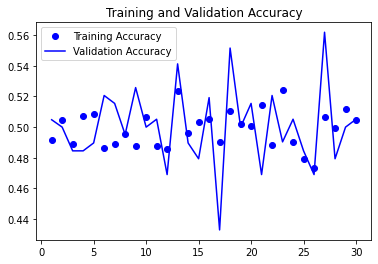

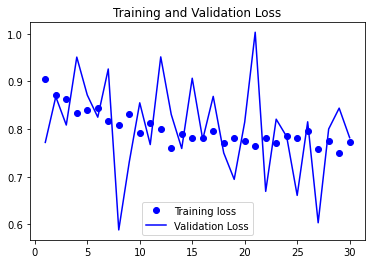

In [126]:
import matplotlib.pyplot as plt

acc = train_metrics.history['accuracy']
val_acc = train_metrics.history['val_accuracy']
loss = train_metrics.history['loss']
val_loss = train_metrics.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [120]:
model.save_weights('model_saved.h5') 